In [1]:
import os

from pathlib import Path
from random import choice

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

from nnunet.training.model_restore import restore_model

from batchgenerators.augmentations.utils import pad_nd_image

# PROJ_ROOT = Path(os.environ['PROJ_ROOT'])
PROJ_ROOT = Path('/home/bruno-pacheco/brats-generalization')

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn

%matplotlib inline

from torch.cuda.amp import autocast

import sys
sys.path.append(os.environ['BRATS_LIB'])
from brats.utils import show_mri



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [1]:
import h5py

from pathlib import Path

import torch

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    
d = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix.hdf5', dataset='train')
d

In [2]:
shapes = list()
for i, l in d:
    shapes.append(i.shape)

ValueError: Index (173920) out of range (0-173919)

<OrthoSlicer3D: /data/slow/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii (193, 229, 193)>

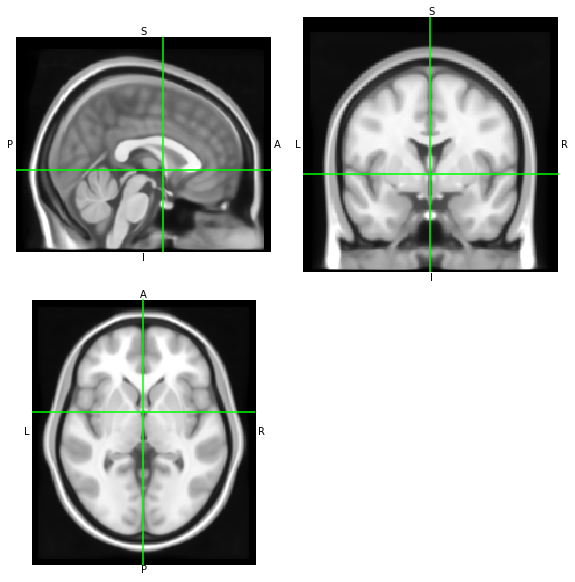

In [14]:
import nibabel as nib

nib.load('/data/slow/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii').orthoview()

<OrthoSlicer3D: (96, 114, 96)>

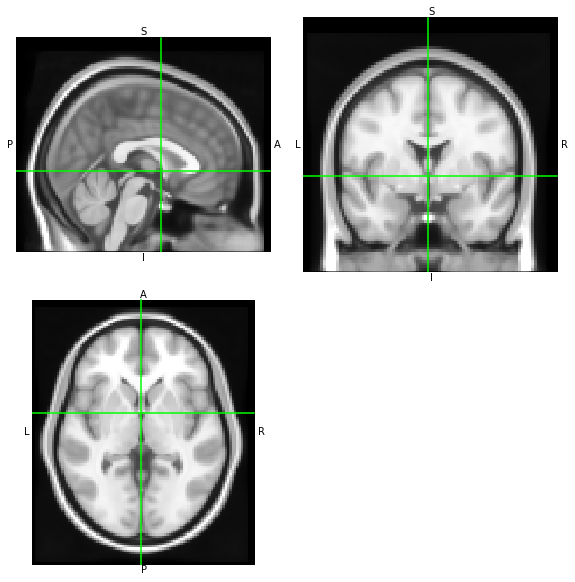

In [27]:
from nibabel.processing import conform
import numpy as np

i_fpath = '/data/slow/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii'
i = nib.load(i_fpath)
j = conform(i, out_shape=tuple(np.array(i.shape) // 2), voxel_size=(2.,2.,2.))
j.orthoview()

In [15]:
nib.load('/data/slow/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii').affine

array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -74.],
       [   0.,    0.,    0.,    1.]])

In [24]:
for l in net.brats_encoder:
    for b in l.blocks:
        b.conv.reset_parameters()
        b.instnorm.reset_parameters()
net.fc.reset_parameters()

ConvDropoutNormNonlin(
  (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
  (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [28]:
net.fc.reset_parameters

<bound method Linear.reset_parameters of Linear(in_features=480, out_features=1, bias=True)>

In [6]:
class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True


net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [2]:
model_dir = PROJ_ROOT/'models/nnUNet/2d/Task112_ADNI_MAPER/nnUNetTrainerV2BraTSRegions_BN_Our__nnUNetPlansv2.1/all'

# contains info about the trainer (aux functions)
model_pkl = model_dir/'model_final_checkpoint.model.pkl'

# model data
model_checkpoint = model_dir/'model_final_checkpoint.model'

trainer = restore_model(model_pkl, checkpoint=model_checkpoint, train=False)

trainer.deterministic

2022-08-23 09:01:30.642288: self.max_num_epochs: 51
2022-08-23 09:01:30.643163: loading checkpoint /home/bruno-pacheco/brats-generalization/models/nnUNet/2d/Task112_ADNI_MAPER/nnUNetTrainerV2BraTSRegions_BN_Our__nnUNetPlansv2.1/all/model_final_checkpoint.model train= False


False

In [3]:
trainer.patch_size

array([192, 160])

In [4]:
trainer.network.do_ds

True

In [8]:
trainer.network

Generic_UNet(
  (conv_blocks_localization): ModuleList(
    (0): Sequential(
      (0): StackedConvLayers(
        (blocks): Sequential(
          (0): ConvDropoutNormNonlin(
            (conv): Conv2d(960, 480, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
            (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
          )
        )
      )
      (1): StackedConvLayers(
        (blocks): Sequential(
          (0): ConvDropoutNormNonlin(
            (conv): Conv2d(480, 480, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
            (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
          )
        )
      )
    )
    (1): Sequential(
      (0): StackedConvLayers(
        (blocks): Sequential(
          (0): ConvDropoutNormNonlin(
            (conv): Conv

# Inference test

using preprocessor PreprocessorFor2D
before crop: (1, 155, 240, 240) after crop: (1, 141, 165, 136) spacing: [1. 1. 1.] 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (1, 141, 165, 136)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (1, 141, 165, 136)} 

normalization...
normalization done


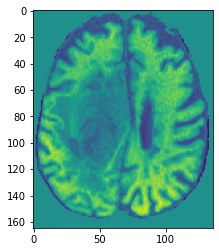

In [3]:
%matplotlib inline

t1_fpath = PROJ_ROOT/'data/raw/MICCAI_BraTS2020_TrainingData/BraTS20_Training_125/BraTS20_Training_125_t1.nii.gz'

brain, mask, properties = trainer.preprocess_patient([str(t1_fpath),])

plt.imshow(brain[0][90])
plt.show()

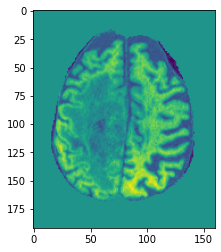

In [4]:
padded_brain, brain_slicer = pad_nd_image(
    brain,
    trainer.patch_size,
    mode='constant',
    kwargs={'constant_values': 0},
    return_slicer=True,
    shape_must_be_divisible_by=trainer.network.input_shape_must_be_divisible_by,
)

plt.imshow(padded_brain[0][100])
plt.show()

In [5]:
padded_brain.shape

(1, 141, 192, 160)

In [123]:
trainer.network.do_ds = False

with autocast():
    with torch.no_grad():
        x = torch.from_numpy(padded_brain).to('cuda')
        x = torch.swapaxes(x,0,1)

        padded_pred = trainer.network.inference_apply_nonlin(trainer.network(x))

padded_pred.shape

torch.Size([141, 4, 192, 160])

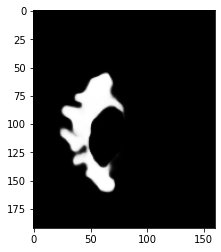

In [129]:
plt.imshow(padded_pred.float().cpu().numpy()[100][1], cmap='gray')
plt.show()

# ADNI Model

In [154]:
type(padded_brain)

numpy.ndarray

In [114]:
x = torch.from_numpy(padded_brain).to('cuda')
x = torch.swapaxes(x,0,1)

# down_convs = list()
# down_convs.append(torch.nn.Conv2d(480,240,kernel_size=1).to('cuda'))
# down_convs.append(torch.nn.Conv2d(240,120,kernel_size=1).to('cuda'))

fc = torch.nn.Linear(480, 1).to('cuda')

with autocast():
    with torch.no_grad():
        for d in range(len(trainer.network.conv_blocks_context)):
            x = trainer.network.conv_blocks_context[d](x)

#         for i in range(len(down_convs)):
#             x = down_convs[i](x)

#         x = torch.nn.functional.avg_pool2d(x, max(x.shape[-2:]))
        x = torch.nn.functional.avg_pool2d(x, 5).squeeze()
#         x = pool(x)

        y = fc(x).squeeze()
y.shape

torch.Size([141])